<a href="https://colab.research.google.com/github/ysnarslan/GlobalAIHubBootcamps/blob/main/DogBreedClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset from Kaggle
We use the dog breed identification dataset from Kaggle. To load this dataset into Colab, we should generate a kaggle.json file. Then we can load the dataset from Kaggle.

## Create kaggle.json File
Go to settings after sign in to Kaggle. In settings, go to the API section. Then you should click on 'Create New Token'. The download will start automatically.

## Upload kaggle.json and Download Dataset
In Colab, we have sections on the left of the screen. We choose folders. After that, you should upload your kaggle.json file. For uploading, you should select the upload option in the top menu.

Now you can run this code. Let's go!

In [1]:
# Load dataset (from Kaggle)

# Make directory name kaggle
! mkdir ~/.kaggle

# Copy the json kaggle to this directory
! cp kaggle.json ~/.kaggle/

# Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle
!kaggle competitions download -c dog-breed-identification

100% 688M/691M [00:31<00:00, 23.8MB/s]
100% 691M/691M [00:31<00:00, 22.8MB/s]


In [8]:
import zipfile
import os

path = 'data/' # Extract path
download_path = '/content/dog-breed-identification.zip' # Dataset path

if not os.path.exists(path):
    os.makedirs(path)

with zipfile.ZipFile(download_path, 'r') as ziphandler:
    ziphandler.extractall(path)

# Import Necessary Libraries
We use pytorch for this project.

In [5]:
!pip install torcheval -qqq
from torcheval.metrics.functional import multiclass_confusion_matrix
import torch
from torch import nn
import torchvision
import cv2
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import PIL.Image
from tqdm.auto import tqdm

# Set Parameters
We set parameters like learnig rate, epoch, batc size etc. in this section.

In [6]:
# Parameters

path_to_csv = '/content/data/labels.csv'
path_to_train = '/content/data/train'
img_size = 256
batch_size = 128

device = 'cuda'
n_epoch = 30
lr = 0.0001
save_epoch = 5
show_epoch = 3

# Create DataFrame
We create a dataframe using pandas and add labels as breed and pixel values of images as Pixel_val.

In [9]:
dataframe = pd.read_csv(path_to_csv)
num_of_img = dataframe.shape[0]
num_of_class = dataframe['breed'].nunique()

dataset = pd.DataFrame(columns=['File_name', 'Breed', 'Pixel_val'])

for i, img_file, label in dataframe.itertuples(index=True):
    img_path = os.path.join(path_to_train, f'{img_file}.jpg')
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    dataset.loc[i] = [img_file, label, cv2.cvtColor(img, cv2.COLOR_BGR2RGB)]

In [10]:
dataset.head()

,File_name,Breed,Pixel_val
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,"[[[137, 77, 29], [176, 119, 69], [151, 102, 50..."
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,"[[[55, 38, 30], [62, 44, 33], [66, 43, 31], [7..."
2,001cdf01b096e06d78e9e5112d419397,pekinese,"[[[100, 99, 93], [110, 109, 104], [114, 113, 1..."
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,"[[[76, 72, 71], [87, 86, 84], [91, 92, 90], [7..."
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,"[[[84, 86, 83], [84, 86, 83], [84, 86, 83], [8..."


# Create Train and Test Datasets
We create X and y variables and split them to train and test. I did not split the train dataset to validation and train. Because we will use k-fold cross validation.


In [11]:
X, y = dataset.drop(columns='Breed'), dataset['Breed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

We define our Dataset class. This class gets files from the train folder. So we reduce memory usage. Because, as we see in the dataframe, storing photos in memory consumes a lot of RAM.

In [12]:
class Dataset(Dataset):
    def __init__(self, X, y, folder_path, img_size):
        self.sizes = [img_size, img_size]
        labels, items = [], []
        y = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(y_train.to_numpy().reshape(-1, 1))

        for data, label in zip(X['File_name'], y):
            item = os.path.join(folder_path, f'{data}.jpg')
            items.append(item)
            labels.append(label)

        self.items = items
        self.labels = labels

    def __getitem__(self, idx):
        data = PIL.Image.open(self.items[idx]).convert('RGB') # size = (x, y)
        data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # size = (128, 128)
        data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False) # shape 128x128x3 to 3x128x128
        data = torch.from_numpy(data).div(255) # values 0-255 to 0-1
        return data, self.labels[idx]

    def __len__(self):
        return len(self.items)

# Show Dataset

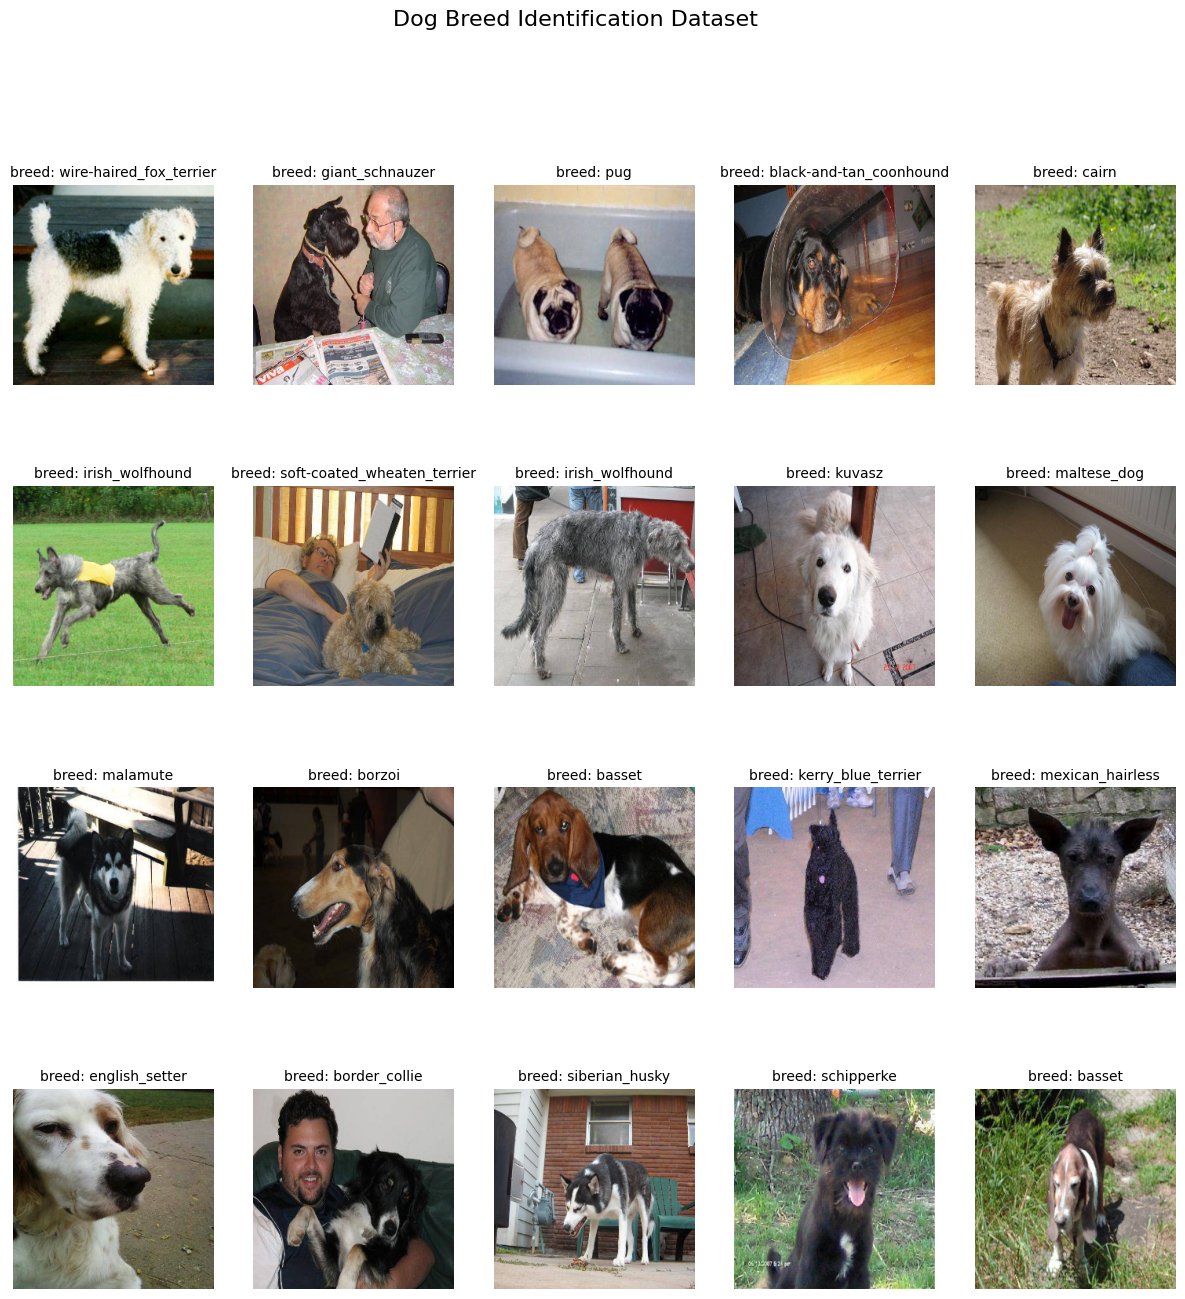

In [9]:
nrow = 4
ncol = 5
fig1 = plt.figure(figsize=(15, 15))
fig1.suptitle('Dog Breed Identification Dataset', size=16)


for i in range(nrow * ncol):
    idx = np.random.randint(len(X))
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(X.loc[idx]['Pixel_val'])
    plt.title(f'breed: {y[idx]}', size=10)
    plt.grid(False)
    plt.axis('Off')

plt.show()

# Create Model
We will use ResNet34 for this project. We can upload this model as pretrained but we want to create it from scratch. Because we want to learn :)

<img src="https://www.researchgate.net/publication/349260577/figure/fig2/AS:990579349528581@1613183929907/A-Basic-Block-building-block-for-ResNet-34.ppm" width=384>

This image shows us the basic block. Image passes through two layers, then we add identity to the processed data. But there is a problem. Identity and processed image shapes could be different. So I decided to add identity after it was processed.






In [13]:
# Model

class BasicBlock(nn.Module):
    def __init__(self, input, out, stride=1):
        super(BasicBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input, out_channels=out, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=out, out_channels=out, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out)
        self.projected = nn.Sequential(nn.Conv2d(input, out, kernel_size=1, stride=2),
                                       nn.BatchNorm2d(out))

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if out.shape[1] == identity.shape[1]:
            out += identity
        else:
            out += self.projected(identity)

        out = self.relu(out)

        return out

After we create the basic block, we should now create the Resnet 34 architecture.


<img src="https://www.researchgate.net/publication/358534483/figure/fig1/AS:1155811321614336@1652578301094/Schematic-diagram-of-the-ResNet-34-architecture-22.png" width="384">

As you see in the image, we have


* 6 convolution layers with 64 filters
* 8 convolution layers with 128 filters
* 12 convolution layers with 256 filters
* 6 convolution layers with 512 filters


We define the first convolution individually. Other layers will be created by the BasicBlock class.

In [14]:
class ResNet34(nn.Module):
    def __init__(self, input, num_classes):
        super(ResNet34, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.block1 = nn.Sequential(
            BasicBlock(64, 64),
            BasicBlock(64, 64),
            BasicBlock(64, 64),
        )
        self.block2 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 128),
        )
        self.block3 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
        )
        self.block4 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512),
            BasicBlock(512, 512),
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.flat = nn.Flatten()
        self.drop = nn.Dropout(0.2)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.max_pool(out)

        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)

        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.drop(out)
        out = self.fc(out)

        return out


Now we can create the model. Our input channel is 3 (RGB image). Output is 120, which is our number of classes. Then we pass the model to the device. We defined the device as 'cuda' in the parameters section. After that, we define our optimizer. We will use Adam. Because Adam converges fast.

In [15]:
model = ResNet34(3, num_of_class)
model.to(device)
model_opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.9))
loss_func = nn.CrossEntropyLoss()
print(model)

ResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (projected): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3

# Training
We define a function for training. This function takes parameters such as model, dataset, loss function, optimizer, epoch number, device, etc.

In [16]:
def train(model, X_train, y_train, loss_func, optimizer, path_to_train, n_epoch=10, batch_size=128, device='cpu', save_epoch=5):
    print(f'Training for {n_epoch} epochs on {device}')
    k_folds = 7
    kfold = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
        # Dividing data into folds
        X_train_fold = X_train.iloc[train_index]
        X_val_fold = X_train.iloc[val_index]
        y_train_fold = y_train.iloc[train_index]
        y_val_fold = y_train.iloc[val_index]


        train = Dataset(X_train_fold, y_train_fold, path_to_train, img_size)
        val = Dataset(X_val_fold, y_val_fold, path_to_train, img_size)
        train_dataloader = DataLoader(train, batch_size = batch_size, shuffle = True)
        val_dataloader = DataLoader(val, batch_size = batch_size, shuffle = True)

        for epoch in range(n_epoch):
            print(f"Epoch {epoch+1}/{n_epoch}")

            model.train()  # put network in train mode for Dropout and Batch Normalization
            train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
            train_accuracy = torch.tensor(0., device=device)
            for data, label in tqdm(train_dataloader):
                data = data.to(device)
                label = label.to(device)

                optimizer.zero_grad()
                preds = model(data)

                loss = loss_func(preds, label)
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    train_loss += loss * train_dataloader.batch_size
                    train_accuracy += (torch.argmax(preds, dim=1) == torch.argmax(label, dim=1)).sum()

            if val_dataloader is not None:
                model.eval()  # put network in train mode for Dropout and Batch Normalization
                val_loss = torch.tensor(0., device=device)
                val_accuracy = torch.tensor(0., device=device)
                with torch.no_grad():
                    for val_data, val_label in val_dataloader:
                        val_data = val_data.to(device)
                        val_label = val_label.to(device)
                        val_preds = model(val_data)
                        val_loss = loss_func(val_preds, val_label)

                        val_loss += val_loss * val_dataloader.batch_size
                        val_accuracy += (torch.argmax(val_preds, dim=1) == torch.argmax(val_label, dim=1)).sum()


            print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
            print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')

            if val_dataloader is not None:
                print(f'Valid loss: {val_loss/len(val_dataloader.dataset):.2f}')
                print(f'Valid accuracy: {100*val_accuracy/len(val_dataloader.dataset):.2f}')

            if epoch % save_epoch==0 and epoch > 0:
                torch.save({
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }, f'./checkpoint-{epoch}.pkl')

                print('Checkpoint saved.')

    return model

We can train our model using the train function.



In [18]:
model = train(model=model,
      X_train=X_train,
      y_train=y_train,
      loss_func=loss_func,
      optimizer=model_opt,
      path_to_train=path_to_train,
      n_epoch=5,
      batch_size=batch_size,
      device=device,
      save_epoch=save_epoch,
      show_epoch=show_epoch)

Training for 5 epochs on cuda
Epoch 1/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.94
Training accuracy: 0.83
Valid loss: 0.55
Valid accuracy: 0.77
Epoch 2/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.85
Training accuracy: 1.17
Valid loss: 0.54
Valid accuracy: 0.86
Epoch 3/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.82
Training accuracy: 1.18
Valid loss: 0.52
Valid accuracy: 0.51
Epoch 4/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.78
Training accuracy: 1.76
Valid loss: 0.53
Valid accuracy: 0.43
Bura yapilacak
Epoch 5/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.65
Training accuracy: 2.97
Valid loss: 0.57
Valid accuracy: 0.94
Epoch 1/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.88
Training accuracy: 0.91
Valid loss: 0.53
Valid accuracy: 1.37
Epoch 2/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.79
Training accuracy: 1.73
Valid loss: 0.52
Valid accuracy: 1.11
Epoch 3/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.55
Training accuracy: 4.27
Valid loss: 0.54
Valid accuracy: 0.94
Epoch 4/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 3.76
Training accuracy: 15.57
Valid loss: 0.62
Valid accuracy: 0.68
Bura yapilacak
Epoch 5/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 2.63
Training accuracy: 41.45
Valid loss: 0.63
Valid accuracy: 0.60
Epoch 1/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 5.04
Training accuracy: 1.08
Valid loss: 0.54
Valid accuracy: 1.03
Epoch 2/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.69
Training accuracy: 2.97
Valid loss: 0.56
Valid accuracy: 1.28
Epoch 3/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 3.72
Training accuracy: 16.38
Valid loss: 0.73
Valid accuracy: 0.86
Epoch 4/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 2.22
Training accuracy: 52.00
Valid loss: 0.71
Valid accuracy: 1.03
Bura yapilacak
Epoch 5/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 1.02
Training accuracy: 83.98
Valid loss: 0.66
Valid accuracy: 0.77
Epoch 1/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 5.17
Training accuracy: 0.91
Valid loss: 0.55
Valid accuracy: 1.03
Epoch 2/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.61
Training accuracy: 4.37
Valid loss: 0.53
Valid accuracy: 0.94
Epoch 3/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 3.25
Training accuracy: 24.70
Valid loss: 0.67
Valid accuracy: 0.68
Epoch 4/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 1.49
Training accuracy: 68.87
Valid loss: 0.68
Valid accuracy: 0.86
Bura yapilacak
Epoch 5/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 0.58
Training accuracy: 92.01
Valid loss: 0.77
Valid accuracy: 0.34
Epoch 1/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 5.19
Training accuracy: 1.11
Valid loss: 0.53
Valid accuracy: 1.11
Epoch 2/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.58
Training accuracy: 4.14
Valid loss: 0.57
Valid accuracy: 0.68
Epoch 3/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 2.98
Training accuracy: 29.63
Valid loss: 0.73
Valid accuracy: 1.28
Epoch 4/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 1.18
Training accuracy: 74.13
Valid loss: 0.73
Valid accuracy: 1.11
Bura yapilacak
Epoch 5/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 0.46
Training accuracy: 92.94
Valid loss: 0.73
Valid accuracy: 0.77
Epoch 1/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 5.23
Training accuracy: 1.20
Valid loss: 0.54
Valid accuracy: 0.94
Epoch 2/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.55
Training accuracy: 4.38
Valid loss: 0.55
Valid accuracy: 0.86
Epoch 3/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 2.82
Training accuracy: 33.49
Valid loss: 0.70
Valid accuracy: 0.86
Epoch 4/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 1.03
Training accuracy: 76.84
Valid loss: 0.73
Valid accuracy: 0.68
Bura yapilacak
Epoch 5/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 0.42
Training accuracy: 92.47
Valid loss: 0.78
Valid accuracy: 1.03
Epoch 1/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 5.28
Training accuracy: 1.00
Valid loss: 0.53
Valid accuracy: 0.51
Epoch 2/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 4.56
Training accuracy: 4.55
Valid loss: 0.58
Valid accuracy: 1.11
Epoch 3/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 2.73
Training accuracy: 35.40
Valid loss: 0.66
Valid accuracy: 0.68
Epoch 4/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 0.95
Training accuracy: 78.19
Valid loss: 0.77
Valid accuracy: 0.60
Bura yapilacak
Epoch 5/5


  0%|          | 0/55 [00:00<?, ?it/s]

Training loss: 0.38
Training accuracy: 93.92
Valid loss: 0.80
Valid accuracy: 0.34


We understand that our training accuracy is really good, but our validation loss is really bad. This means our model is overfitting or our dataset is imbalanced.


Also, in classification problems, accuracy is not the best metric to measure our model's performance. We will create a confusion matrix. Then we can obtain other metrics, like precision and recall.

In [19]:
# We can load models

def load_checkpoint(name, model, model_opt):
    checkpoint = torch.load(f'./checkpoint-{name}.pkl')
    model.load_state_dict(checkpoint['state_dict'])
    model_opt.load_state_dict(checkpoint['optimizer'])

In [20]:
preds = []
real = []
train_accuracy = []
target = np.zeros(0)
out = np.zeros(0)
model.eval()
test_dataloader = DataLoader(Dataset(X_test, y_test, path_to_train, img_size), batch_size=batch_size)
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        bs = X.shape[0]
        preds = model(X)
        target = np.append(target, torch.argmax(y, dim=1).to('cpu').flatten()).astype(int)
        out = np.append(out, torch.argmax(preds, dim=1).to('cpu').flatten()).astype(int)
        train_accuracy.append(((torch.argmax(preds, dim=1) == torch.argmax(y, dim=1)).sum() / bs).to('cpu'))


conf_matrix = multiclass_confusion_matrix(torch.tensor(out), torch.tensor(target), num_of_class)
acc = np.array(train_accuracy).mean()
print(acc)

0.0117539065


In [26]:
print("Train set average image for each class: ", y_train.value_counts().mean())
print("Test set average image for each class: ", y_test.value_counts().mean())

Train set average image for each class:  68.14166666666667
Test set average image for each class:  17.041666666666668


# Conclusion
As you see, we have an average of 17 photos for each class in the test dataset. In the training dataset, each class had an average of 68 photos. This dataset is not enough to learn. So we should use a pre-trained model. But the purpose of this project is not high performance. My purpose is to learn how to create a model from scratch using pytorch. And we made it!

In [21]:
recall = np.array([x[id] / x.sum() for id, x in enumerate(conf_matrix)]).mean()
print(recall)

0.01076076


In [22]:
precision = np.array([0 if x.sum() == 0 else x[id] / x.sum() for id, x in enumerate(np.rollaxis(conf_matrix.numpy(), 1))]).mean()
print(precision)

0.006831698460949091
